In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch import from_numpy
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np


## ETL

In [3]:
# Load the data
folder = 'data/Iris.csv'
data = pd.read_csv(folder)

# Display the first few rows of the data
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# Drop the Id column
data = data.drop(columns=['Id'])

# Separate features and target
X = data.drop(columns=['Species']).values
y = data['Species'].values

In [14]:
# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Convert numpy arrays to PyTorch tensors
X = from_numpy(X).float()
y = from_numpy(y).long()

# Convert labels to one-hot encoding
#y = torch.nn.functional.one_hot(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Determine the number of classes
num_classes = max(y) + 1
num_features = X.shape[1]

num_classes, num_features

(tensor(3), 4)

## Model and train

In [20]:
class MLPWithActivations(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(MLPWithActivations, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.layer3 = nn.Linear(hidden_size2, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
        # Activations placeholder
        self.activations = {}
        
    def forward(self, x):
        self.activations['input'] = x
        # layer 1
        out = self.layer1(x)
        out = self.relu(out)
        self.activations['layer1'] = out

        #layer 2
        out = self.layer2(out)
        out = self.relu(out)
        self.activations['layer2'] = out

        #layer 3
        out = self.layer3(out)
        out = self.softmax(out)
        self.activations['layer3'] = out
        
        return out

In [16]:
# Convert data to tensors
tensor_x_train = torch.Tensor(X_train)
tensor_y_train = torch.Tensor(y_train)
tensor_x_test = torch.Tensor(X_test)
tensor_y_test = torch.Tensor(y_test,)

# Create a TensorDataset from the data
train_data = TensorDataset(tensor_x_train, tensor_y_train)
test_data = TensorDataset(tensor_x_test, tensor_y_test)

# Create a DataLoader from the TensorDataset
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [21]:
# Initialize the MLP
model = MLPWithActivations(num_features, 100, 20, num_classes)

# Define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Function to perform a training step
def train_step(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0
    corrects = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = corrects.double() / len(train_loader.dataset)
    return epoch_loss, epoch_acc.item()

# Train the model for 10 epochs
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_step(model, train_loader, criterion, optimizer)
    print(f'Epoch: {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Acc: {train_acc:.4f}')


Epoch: 1/10 | Loss: 1.0893 | Acc: 0.4750
Epoch: 2/10 | Loss: 1.0671 | Acc: 0.8583
Epoch: 3/10 | Loss: 1.0446 | Acc: 0.8583
Epoch: 4/10 | Loss: 1.0214 | Acc: 0.8750
Epoch: 5/10 | Loss: 0.9971 | Acc: 0.8750
Epoch: 6/10 | Loss: 0.9712 | Acc: 0.8667
Epoch: 7/10 | Loss: 0.9445 | Acc: 0.8583
Epoch: 8/10 | Loss: 0.9183 | Acc: 0.8667
Epoch: 9/10 | Loss: 0.8928 | Acc: 0.8833
Epoch: 10/10 | Loss: 0.8691 | Acc: 0.8833


In [22]:
# Pass a sample input through the model to get the activations
sample_input = X_train[0].unsqueeze(0)
sample_output = model(sample_input)

# Print the activations
for name, activation in model.activations.items():
    print(f'{name}: {activation}')

input: tensor([[-1.5065,  1.2635, -1.5687, -1.3130]])
layer1: tensor([[0.8293, 2.1183, 1.8905, 0.0000, 0.0539, 0.3897, 0.0000, 1.0235, 2.2961,
         0.5299, 0.0000, 0.0000, 1.0632, 0.0000, 0.0000, 1.6067, 0.3940, 0.1763,
         0.0000, 0.0000, 0.0000, 0.0000, 0.6267, 0.8636, 0.0000, 1.1244, 0.0000,
         0.7353, 0.0000, 0.7283, 0.9488, 0.7551, 0.0000, 0.0000, 0.6621, 0.3543,
         1.1983, 0.0000, 0.6112, 1.3805, 0.5792, 0.0000, 0.0000, 1.0338, 0.0000,
         1.7659, 0.0000, 0.0000, 0.2169, 1.3732, 0.5909, 0.0000, 0.2914, 0.0000,
         0.0000, 0.0000, 0.0000, 0.3308, 0.0000, 0.0000, 1.1315, 0.6799, 0.5818,
         0.0000, 0.5855, 1.4074, 0.0000, 0.0000, 0.3075, 0.0000, 0.0000, 0.0000,
         1.0826, 0.0000, 0.4055, 0.0000, 0.0000, 0.3734, 0.0000, 0.6294, 1.2106,
         1.4916, 0.0000, 0.0000, 0.5037, 0.6774, 0.0000, 0.0000, 0.0000, 0.0000,
         1.5010, 0.0000, 0.0000, 0.3873, 1.4668, 1.2944, 0.0000, 0.6617, 0.0000,
         0.2249]], grad_fn=<ReluBackward0>)
lay

## Activation function

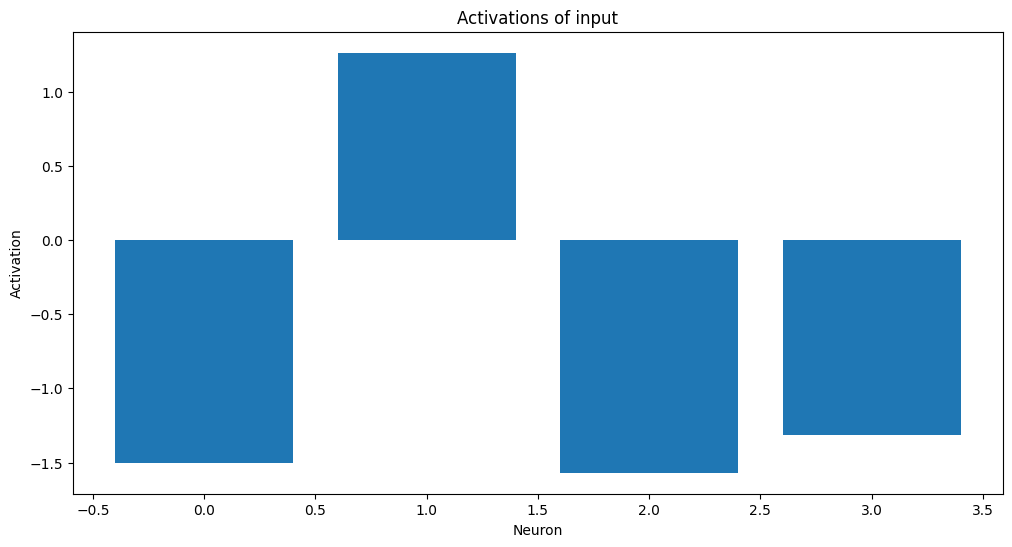

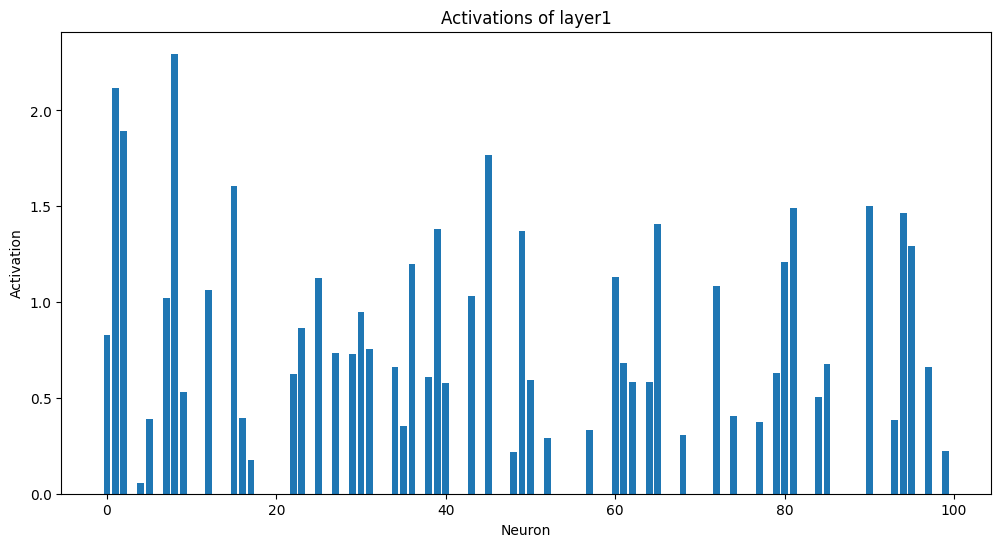

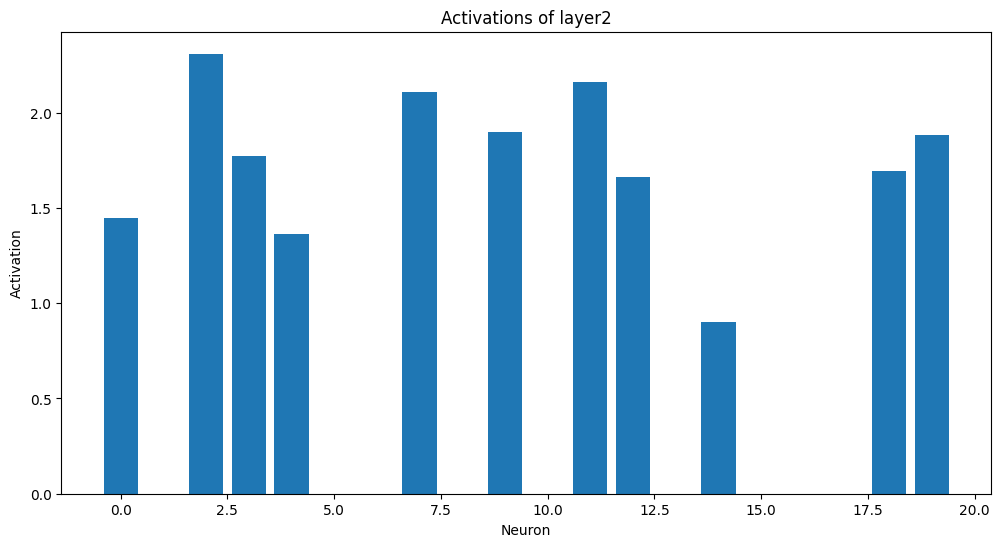

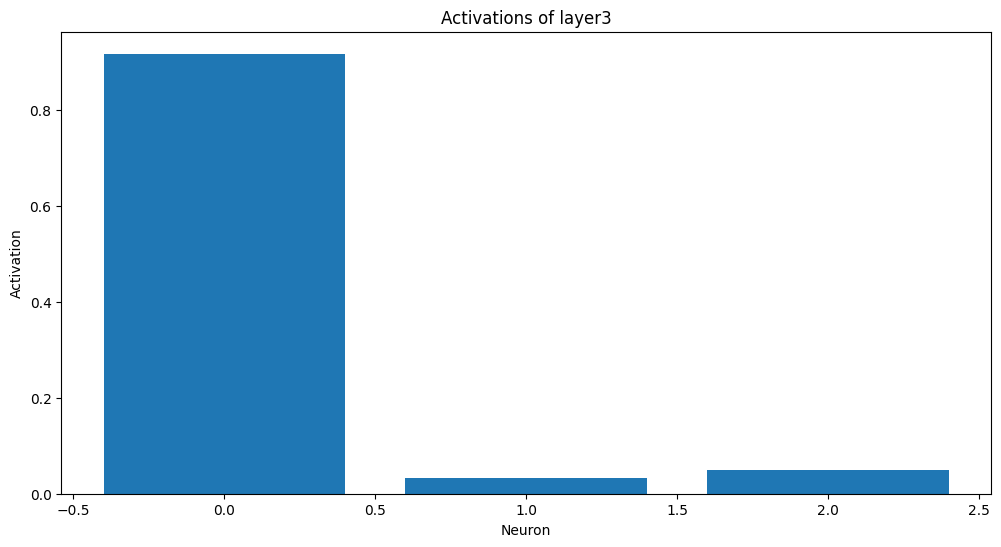

In [23]:
# Function to plot the activations
def plot_activations(activations):
    for layer_name, activation in activations.items():
        plt.figure(figsize=(12, 6))
        plt.bar(range(activation.shape[1]), activation.detach().numpy()[0])
        plt.title(f'Activations of {layer_name}')
        plt.xlabel('Neuron')
        plt.ylabel('Activation')
        plt.show()

# Plot the activations
plot_activations(model.activations)

In [24]:
from sklearn.utils import resample

# Convert test data back to DataFrame for easier manipulation
df_test = pd.DataFrame(tensor_x_test.numpy(), columns=data.columns[:-1])
df_test['Species'] = tensor_y_test.numpy()

# Separate the test data by class
df_test_setosa = df_test[df_test['Species'] == 0]
df_test_versicolor = df_test[df_test['Species'] == 1]
df_test_virginica = df_test[df_test['Species'] == 2]

# Find the number of examples in the smallest class
min_examples = min(len(df_test_setosa), len(df_test_versicolor), len(df_test_virginica))

# Resample each class to have the same number of examples as the smallest class
df_test_setosa_resampled = resample(df_test_setosa, replace=False, n_samples=min_examples, random_state=42)
df_test_versicolor_resampled = resample(df_test_versicolor, replace=False, n_samples=min_examples, random_state=42)
df_test_virginica_resampled = resample(df_test_virginica, replace=False, n_samples=min_examples, random_state=42)

# Concatenate the resampled dataframes back together
df_test_balanced = pd.concat([df_test_setosa_resampled, df_test_versicolor_resampled, df_test_virginica_resampled])

# Separate features and labels
X_test_balanced = df_test_balanced.drop(columns=['Species']).values
y_test_balanced = df_test_balanced['Species'].values

# Convert to PyTorch tensors
X_test_balanced = torch.Tensor(X_test_balanced)
y_test_balanced = torch.LongTensor(y_test_balanced)

X_test_balanced.shape, y_test_balanced.shape


(torch.Size([27, 4]), torch.Size([27]))

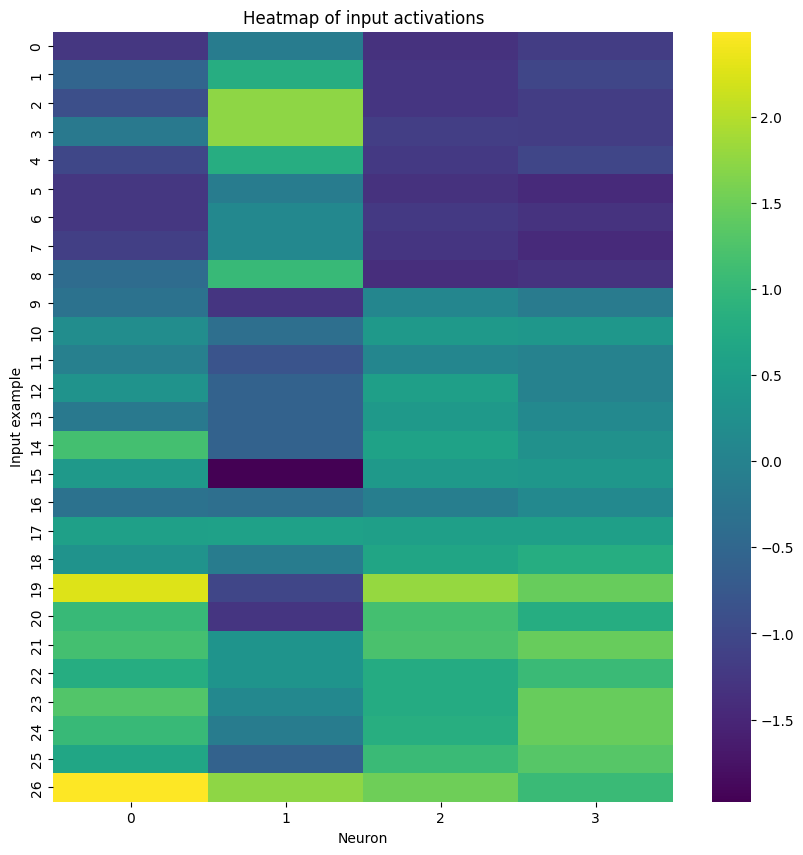

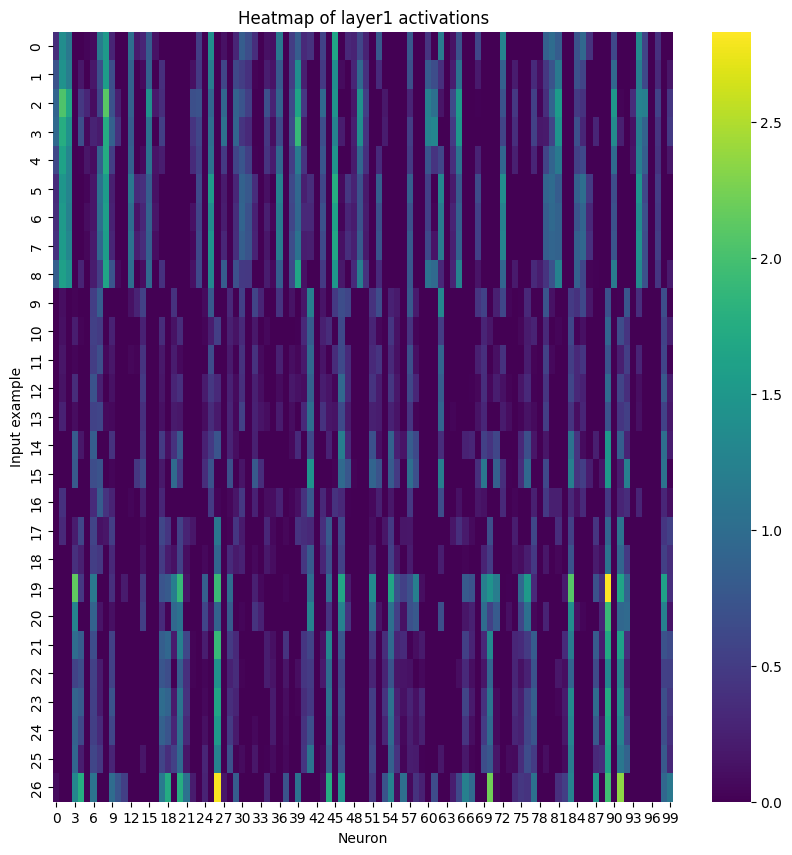

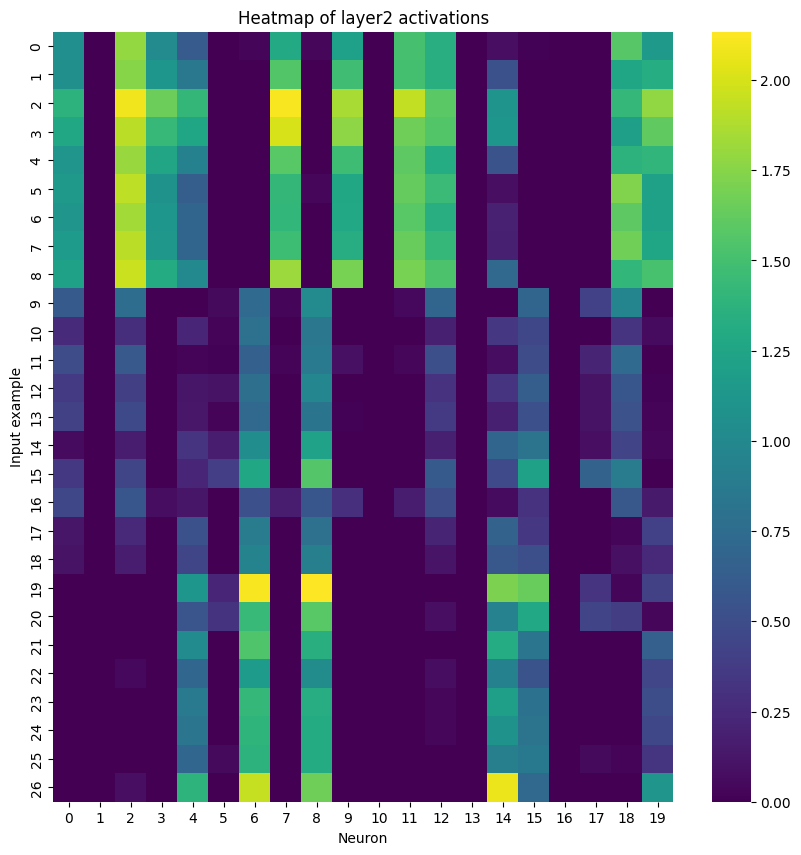

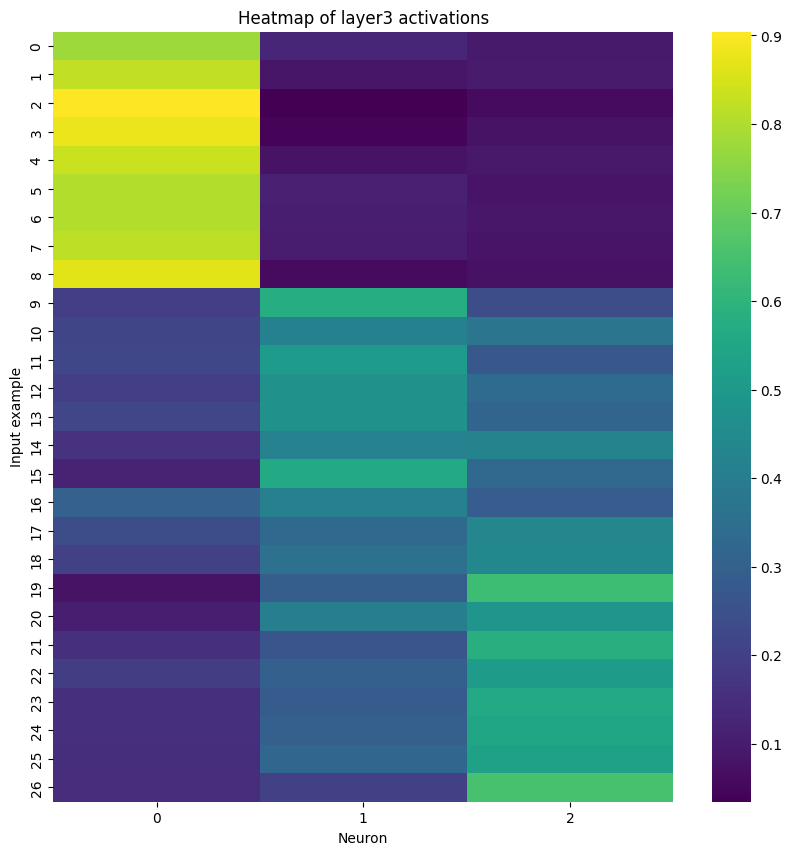

In [25]:
import seaborn as sns

# Function to plot the heatmaps of activations
def plot_activation_heatmaps(model, inputs):
    # Pass inputs through the model
    outputs = model(inputs)
    # Create a heatmap for each layer's activations
    for layer_name, activation in model.activations.items():
        plt.figure(figsize=(10, 10))
        sns.heatmap(activation.detach().numpy(), cmap='viridis')
        plt.title(f'Heatmap of {layer_name} activations')
        plt.xlabel('Neuron')
        plt.ylabel('Input example')
        plt.show()

# Plot the activation heatmaps
plot_activation_heatmaps(model, X_test_balanced)


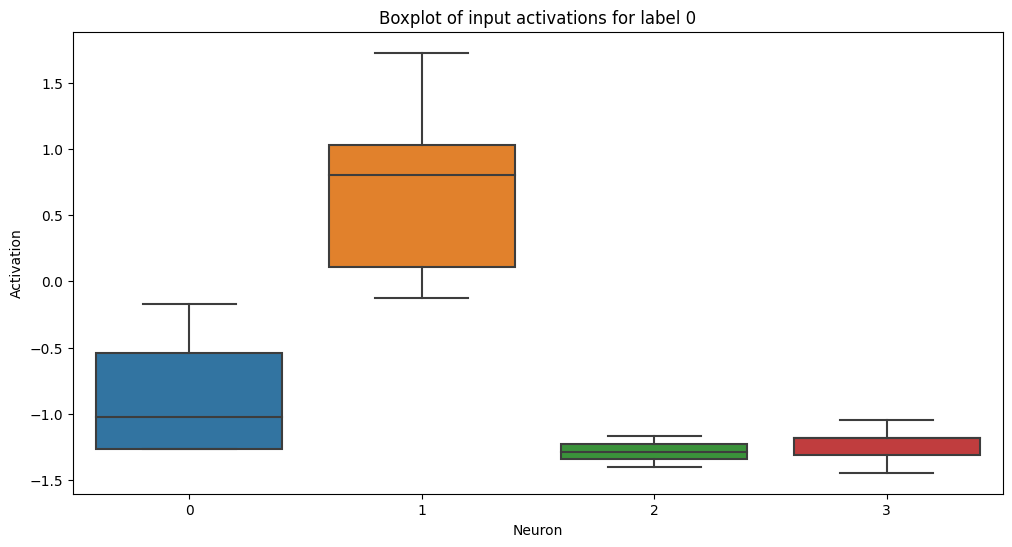

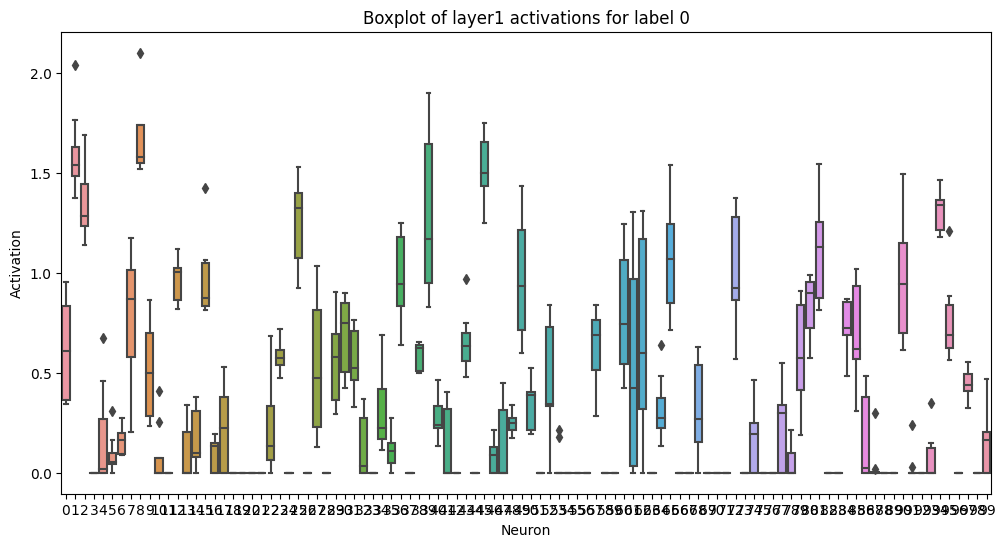

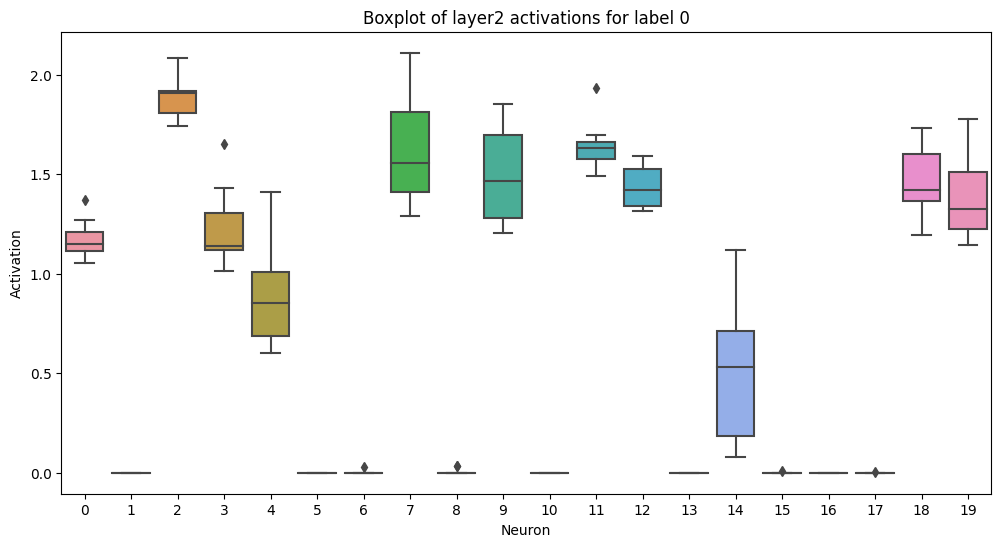

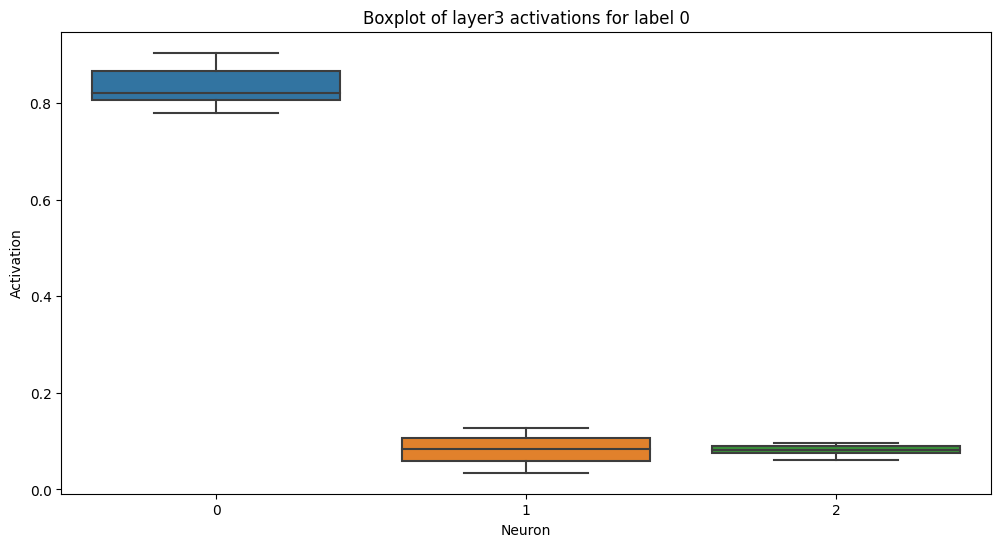

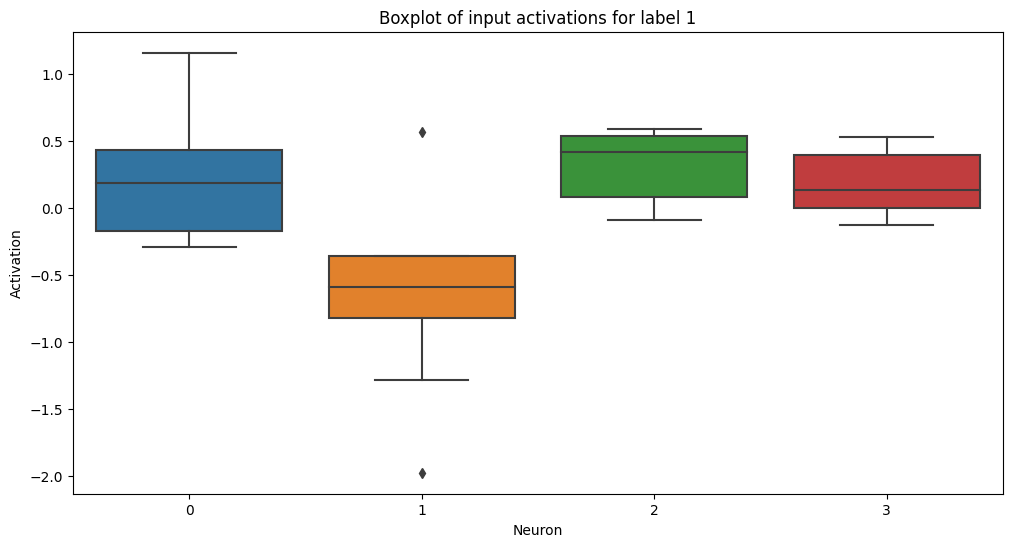

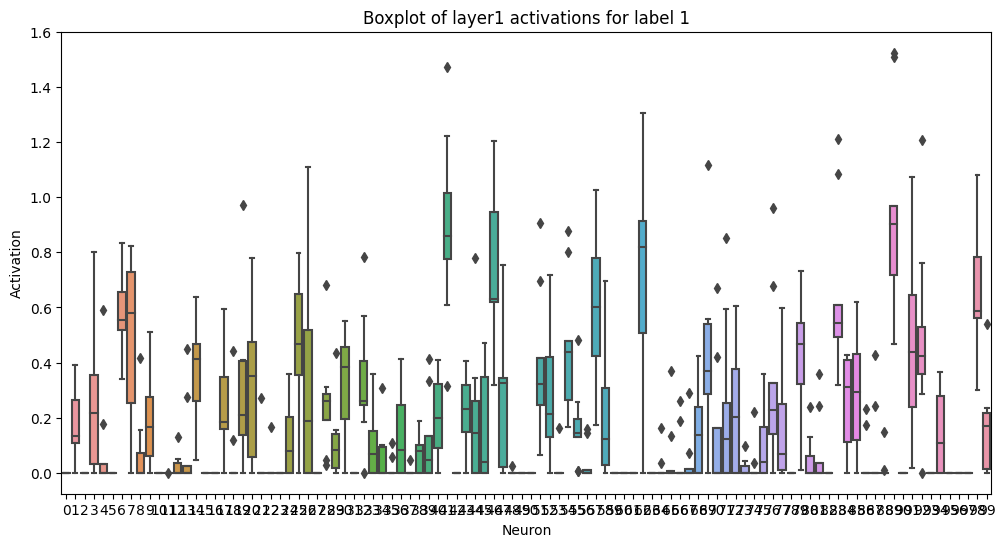

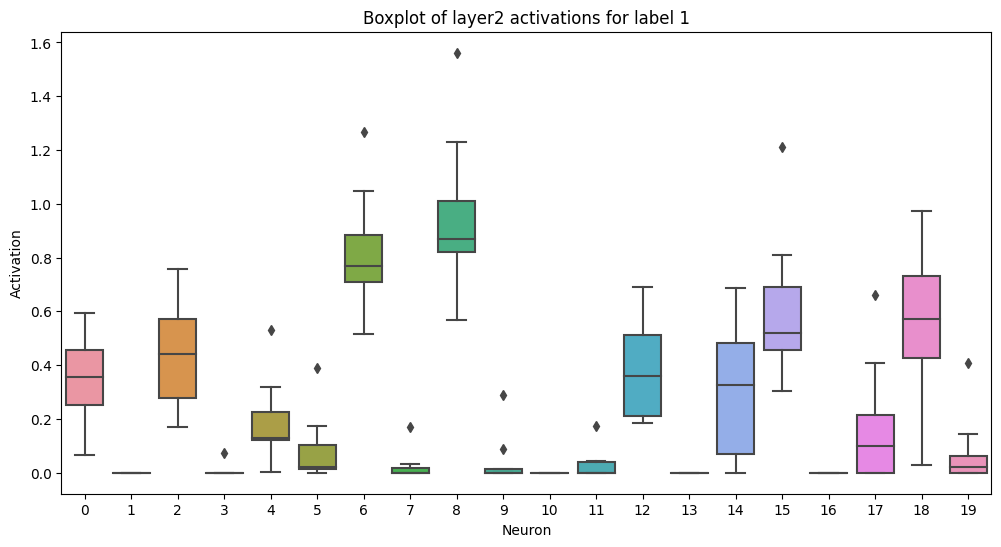

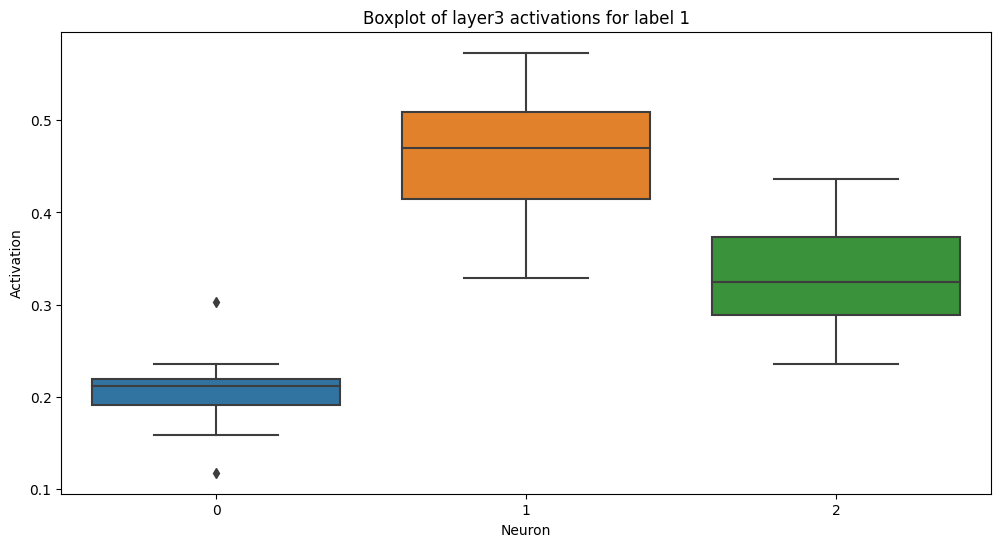

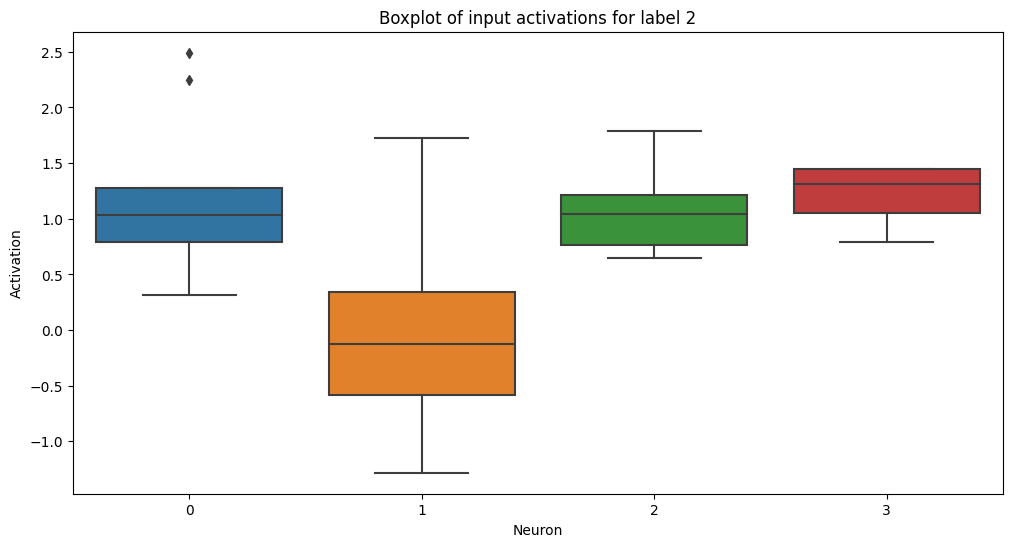

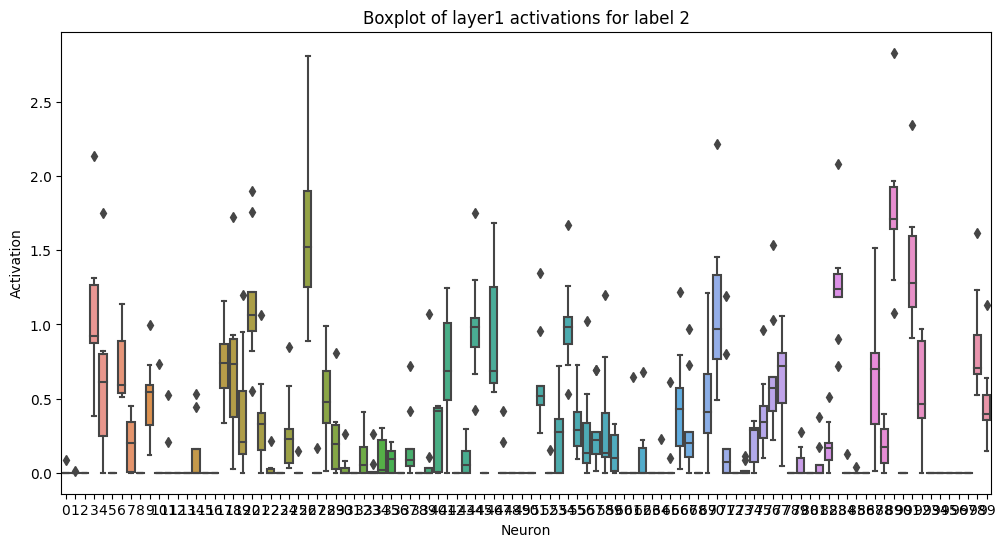

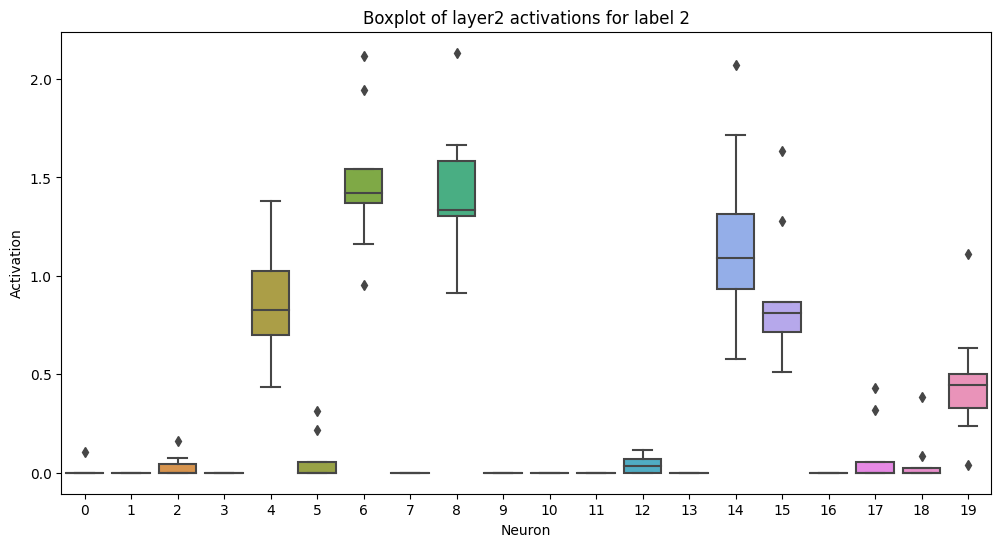

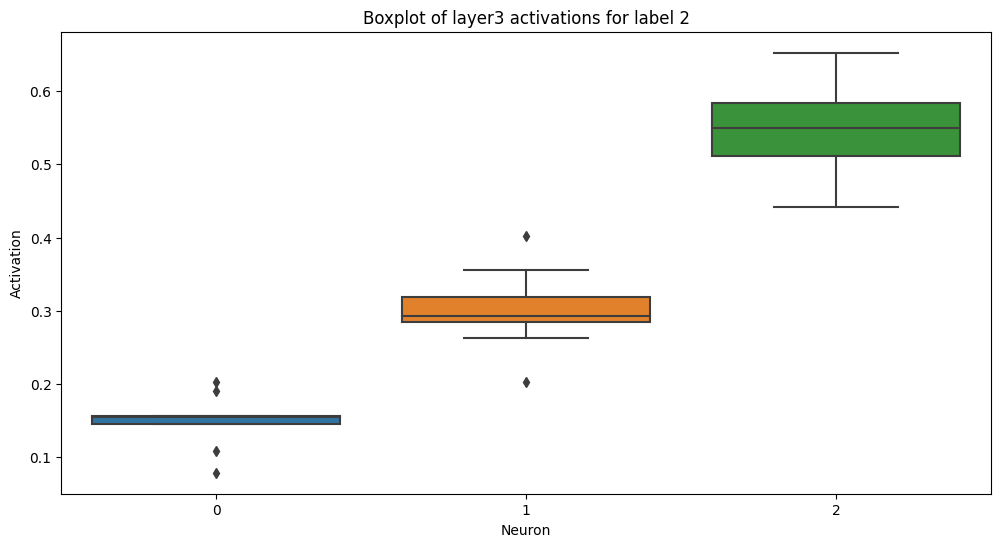

In [26]:
# Function to get activations for each class
def get_activations_for_each_class(model, inputs, labels):
    unique_labels = torch.unique(labels).tolist()
    activations = {label: {} for label in unique_labels}
    for label in unique_labels:
        label_inputs = inputs[labels == label]
        model(label_inputs)
        for layer_name, layer_activations in model.activations.items():
            activations[label][layer_name] = layer_activations.detach().numpy()
    return activations

# Get activations for each class
activations = get_activations_for_each_class(model, X_test_balanced, y_test_balanced)

# Plot boxplots of activations for each class
for label, label_activations in activations.items():
    for layer_name, layer_activations in label_activations.items():
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=layer_activations)
        plt.title(f'Boxplot of {layer_name} activations for label {label}')
        plt.xlabel('Neuron')
        plt.ylabel('Activation')
        plt.show()


## Clustering

In [29]:
data_dict_result = {}
for name, activation in model.activations.items():
    data_dict_result[name] = activation.detach().numpy()

In [35]:
# Apilar las activaciones de todos los ejemplos en un único array de numpy para cada capa
layer1_activations = np.vstack([data_dict for data_dict in data_dict_result['layer1']])
layer2_activations = np.vstack([data_dict for data_dict in data_dict_result["layer2"]])
layer3_activations = np.vstack([data_dict for data_dict in data_dict_result["layer3"]])

In [36]:
# Normalizar los datos
layer1_activations = (layer1_activations - layer1_activations.min()) / (layer1_activations.max() - layer1_activations.min())
layer2_activations = (layer2_activations - layer2_activations.min()) / (layer2_activations.max() - layer2_activations.min())
layer3_activations = (layer3_activations - layer3_activations.min()) / (layer3_activations.max() - layer3_activations.min())


In [37]:
from sklearn.cluster import KMeans

# Define el número de clusters
n_clusters = 3

# Inicializa KMeans
kmeans_layer1 = KMeans(n_clusters=n_clusters)
kmeans_layer2 = KMeans(n_clusters=n_clusters)
kmeans_layer3 = KMeans(n_clusters=n_clusters)

# Ajusta los datos
kmeans_layer1.fit(layer1_activations)
kmeans_layer2.fit(layer2_activations)
kmeans_layer3.fit(layer3_activations)

# Obtiene las etiquetas de los clusters
labels_layer1 = kmeans_layer1.labels_
labels_layer2 = kmeans_layer2.labels_
labels_layer3 = kmeans_layer3.labels_


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


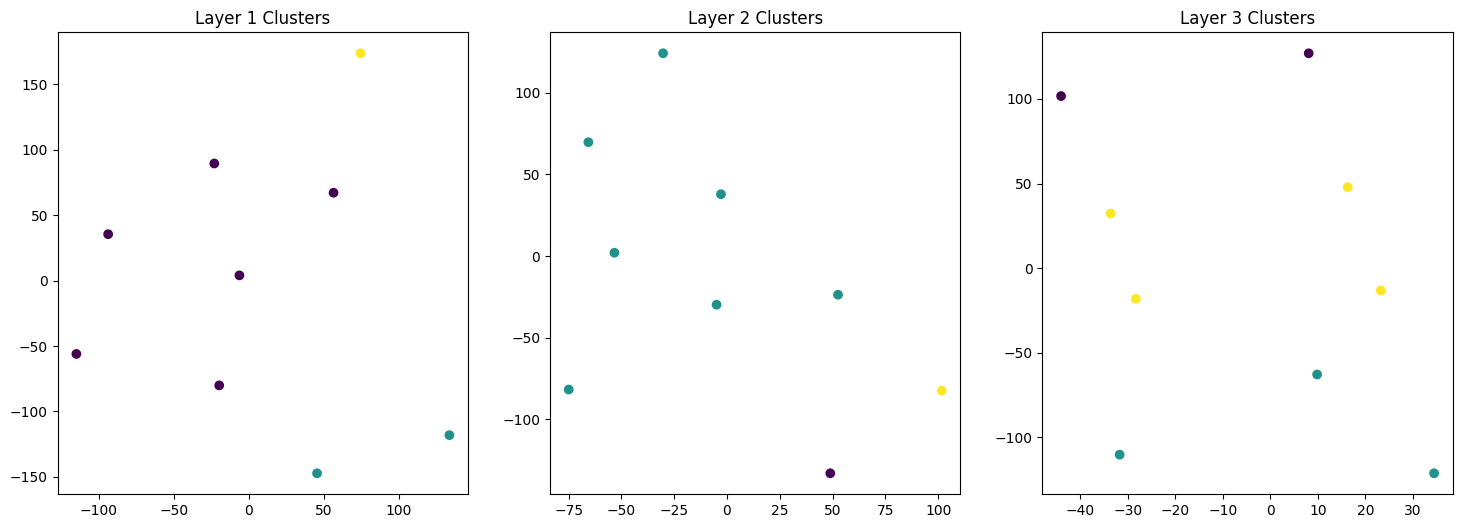

In [44]:
from sklearn.manifold import TSNE

# Inicializa t-SNE
tsne = TSNE(n_components=2, perplexity=5)

# Aplica t-SNE a los datos
layer1_activations_tsne = tsne.fit_transform(layer1_activations)
layer2_activations_tsne = tsne.fit_transform(layer2_activations)
layer3_activations_tsne = tsne.fit_transform(layer3_activations)

# Grafica los resultados
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(layer1_activations_tsne[:, 0], layer1_activations_tsne[:, 1], c=labels_layer1)
plt.title('Layer 1 Clusters')

plt.subplot(1, 3, 2)
plt.scatter(layer2_activations_tsne[:, 0], layer2_activations_tsne[:, 1], c=labels_layer2)
plt.title('Layer 2 Clusters')

plt.subplot(1, 3, 3)
plt.scatter(layer3_activations_tsne[:, 0], layer3_activations_tsne[:, 1], c=labels_layer3)
plt.title('Layer 3 Clusters')

plt.show()


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


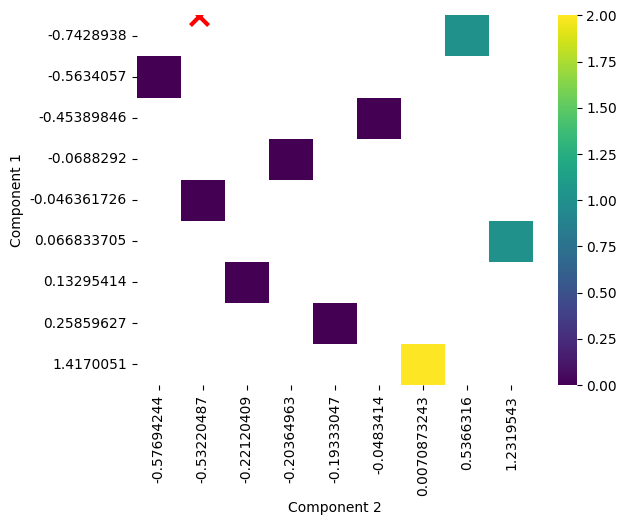

In [46]:
import seaborn as sns
from sklearn.decomposition import PCA

# Asumamos que layer1_activations es un array 2D con las activaciones de las neuronas de la capa 1.
pca = PCA(n_components=2)
activations_pca = pca.fit_transform(layer1_activations)

# Ajusta los datos con KMeans
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(layer1_activations)

# Obtiene las etiquetas de los clusters
labels = kmeans.labels_

# Obtiene los centroides de los clusters en el espacio original de alta dimensión y los transforma a 2D con PCA
centroids = pca.transform(kmeans.cluster_centers_)

# Crea un DataFrame para facilitar la traza
df = pd.DataFrame(activations_pca, columns=["Component 1", "Component 2"])
df["Cluster"] = labels

# Crea una figura y un set de ejes
fig, ax = plt.subplots()

# Traza un mapa de calor de las activaciones
sns.heatmap(df.pivot(index="Component 1", columns="Component 2", values="Cluster"), ax=ax, cmap="viridis")

# Traza los centroides de los clusters
ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3, color='r', zorder=10)

plt.show()


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_25016\2824468870.py:28: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df[df["Cluster"] == i], x="Component 1", y="Component 2", fill=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_25016\2824468870.py:28: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df[df["Cluster"] == i], x="Component 1", y="Component 2", fill=True)


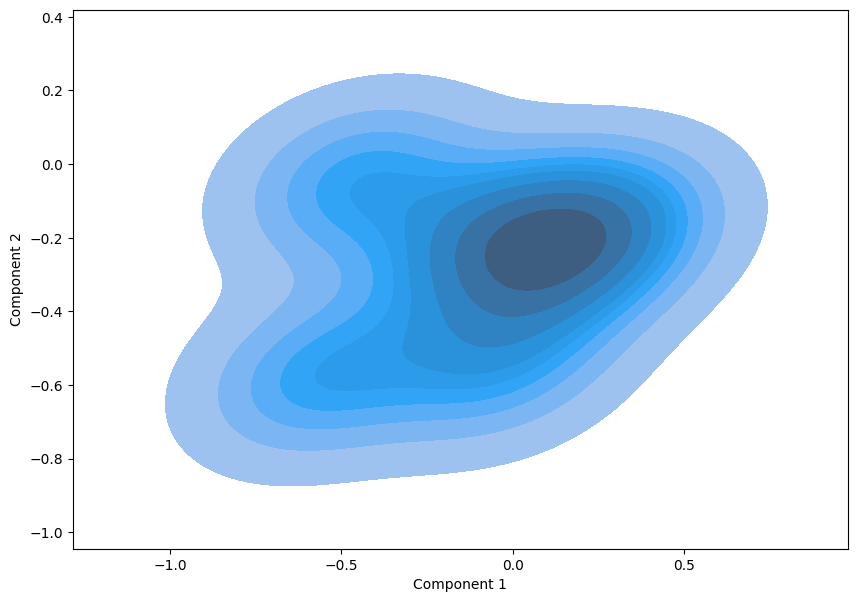

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Inicializa PCA
pca = PCA(n_components=2)

# Aplica PCA a los datos
activations_pca = pca.fit_transform(layer1_activations)

# Ajusta los datos con KMeans
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(layer1_activations)

# Obtiene las etiquetas de los clusters
labels = kmeans.labels_

# Crea un DataFrame para facilitar la traza
df = pd.DataFrame(activations_pca, columns=["Component 1", "Component 2"])
df["Cluster"] = labels

# Inicializa la figura
plt.figure(figsize=(10, 7))

# Traza la trama KDE
for i in range(n_clusters):
    sns.kdeplot(data=df[df["Cluster"] == i], x="Component 1", y="Component 2", fill=True)

# Muestra la trama
plt.show()


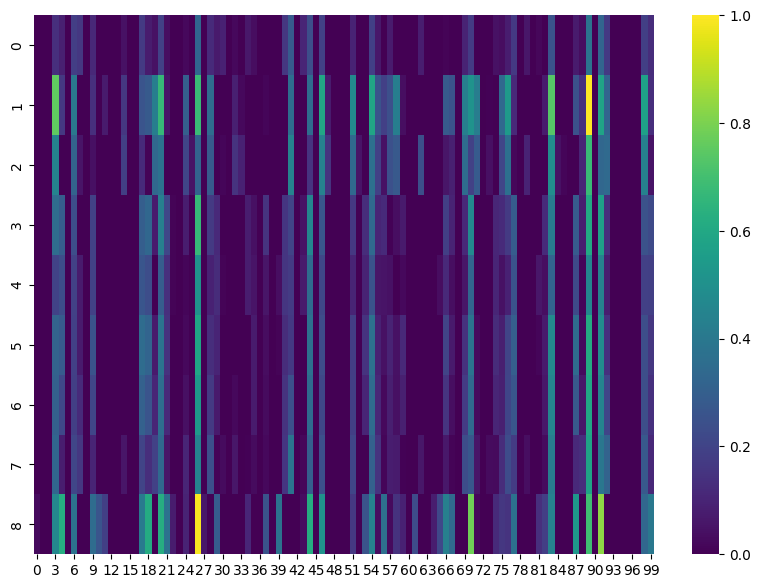

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asumamos que layer1_activations es un array 2D con las activaciones de las neuronas de la capa 1.

# Crea una figura y un set de ejes
fig, ax = plt.subplots(figsize=(10, 7))

# Traza un mapa de calor de las activaciones
sns.heatmap(layer1_activations, ax=ax, cmap="viridis")

# Muestra la trama
plt.show()


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


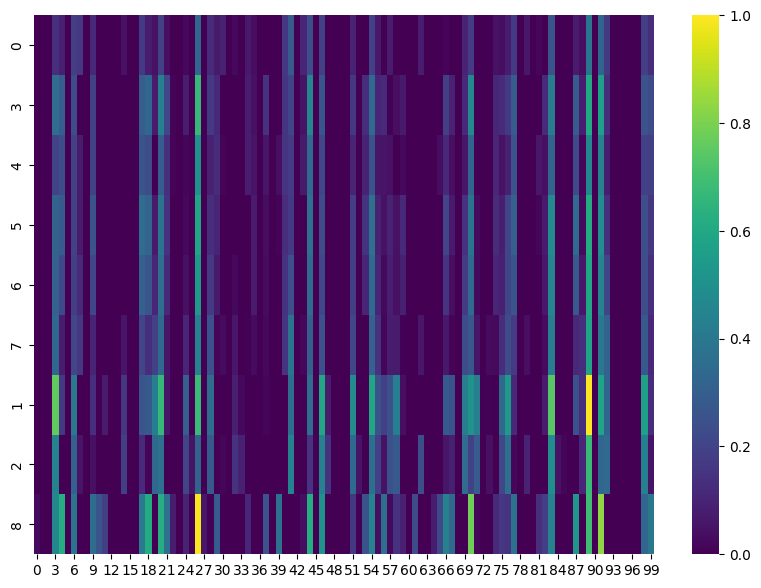

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Define el número de clusters
n_clusters = 3

# Ajusta los datos con KMeans
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(layer1_activations)

# Obtiene las etiquetas de los clusters
labels = kmeans.labels_

# Crea un DataFrame con las activaciones y las etiquetas de los clusters
df = pd.DataFrame(layer1_activations)
df['Cluster'] = labels

# Ordena el DataFrame por las etiquetas de los clusters
df.sort_values('Cluster', inplace=True)

# Elimina la columna 'Cluster' antes de trazar el mapa de calor
df.drop('Cluster', axis=1, inplace=True)

# Traza un mapa de calor de las activaciones
plt.figure(figsize=(10, 7))
sns.heatmap(df, cmap="viridis")
plt.show()


In [50]:
from sklearn.cluster import KMeans

# Transpón la matriz de activaciones para que cada fila corresponda a una neurona
activations_transposed = layer1_activations.T

# Aplica K-means a las neuronas
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(activations_transposed)

# Obtiene las etiquetas de los clusters para cada neurona
neuron_labels = kmeans.labels_

# Crea una lista de neuronas para cada cluster
neuron_clusters = {i: [] for i in range(n_clusters)}
for i, label in enumerate(neuron_labels):
    neuron_clusters[label].append(i)

# Ahora, neuron_clusters es un diccionario donde las claves son los identificadores de los clusters
# y los valores son las listas de las neuronas en cada cluster


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


def neuron_map_cluster(layer, title):
    # Transpón la matriz de activaciones para que cada fila corresponda a una neurona
    activations_transposed = layer.T

    # Aplica K-means a las neuronas
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(activations_transposed)

    # Obtiene las etiquetas de los clusters para cada neurona
    neuron_labels = kmeans.labels_

    # Crea un DataFrame con las activaciones y las etiquetas de los clusters
    df = pd.DataFrame(activations_transposed)
    df['Cluster'] = neuron_labels
    
    # Ordena el DataFrame por las etiquetas de los clusters
    df.sort_values('Cluster', inplace=True)

    # Elimina la columna 'Cluster' antes de trazar el mapa de calor
    activations_ordered = df.drop('Cluster', axis=1).values

    # Traza un mapa de calor de las activaciones
    plt.figure(figsize=(10, 7))
    sns.heatmap(activations_ordered, cmap="viridis")
    plt.title(title)
    plt.ylabel("Neurons")
    plt.xlabel("Dimensions")
    plt.show()


c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


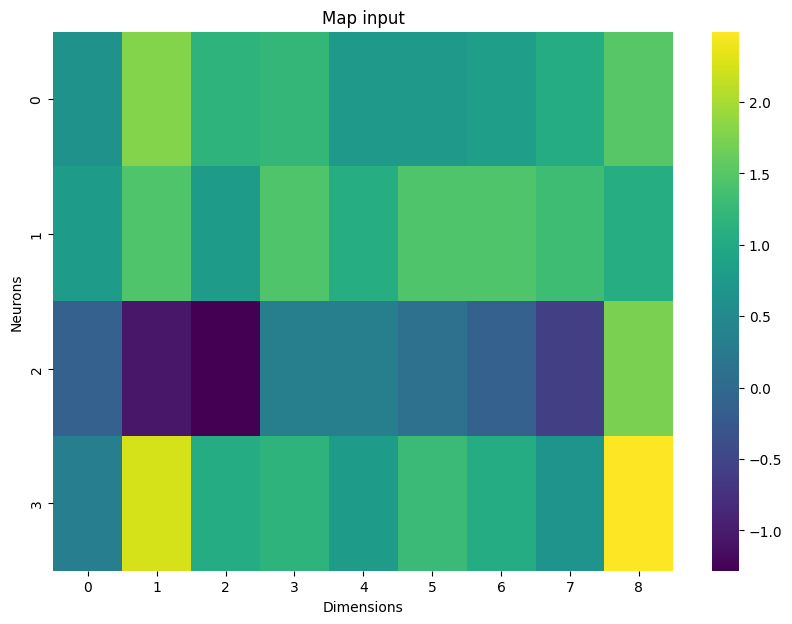

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


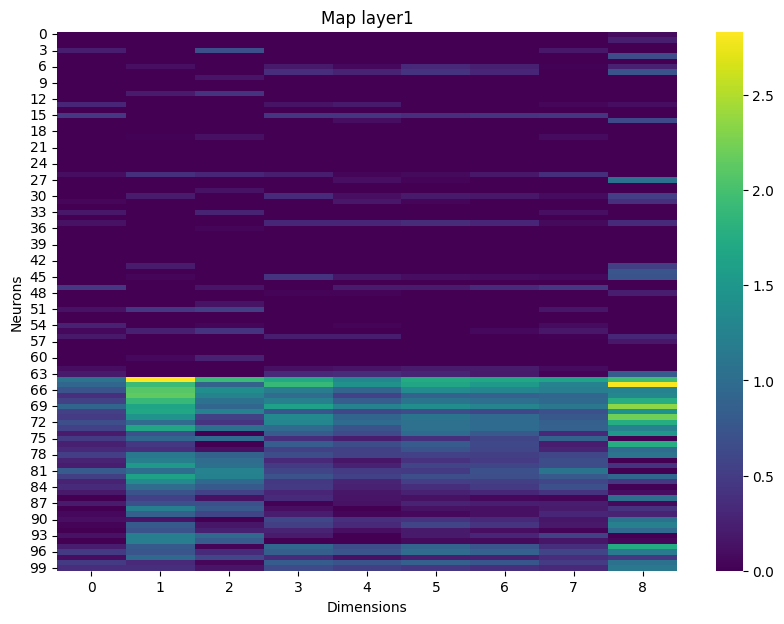

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


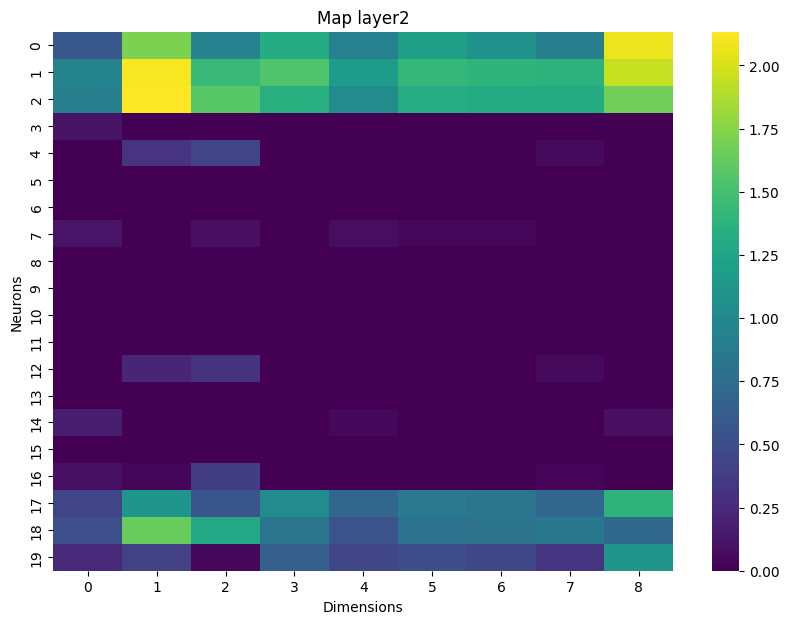

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


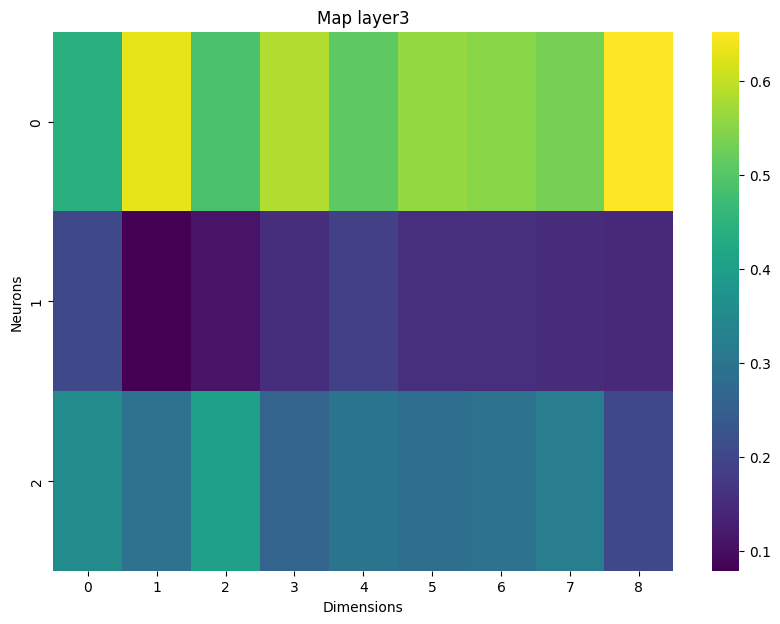

In [73]:
for layer in  data_dict_result.keys():
    neuron_map_cluster(data_dict_result[layer], f'Map {layer}')